## Pre-requisites

- Required Python packages:
    - Pandas for dataframes
    - Numpy for number calculations
    - Matplotlib & Seaborn for plotting
    - TQDM for tracking loop progress
    - Time for time tracking
- Import the environment functions defined in Part 1 from the env.py file

In [1]:
# Default Imports
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure

import tqdm
import time

import warnings
warnings.filterwarnings("ignore")

# Figure Formatting
sns.set(rc={'figure.figsize':(15, 10)})
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 5})
sns.set_style("whitegrid", {'axes.grid' : False})

# Import environment from env.py
from env import action_outcome
from env import environment
#------------------------------------------------------------------------------------------


# Part 2 - Model Based Methods

## Optimal Policy for Environment with Known Probabilities

### Model-based Methods
The aim is for us to find the optimal action in each state as the paper is passed in a given direction. 

If we assume that the probabilities are known, we can actually use model-based methods and will demonstrate this first and can use value iteration to achieve this via the following formula:

\begin{equation}
    Q_{k+1}(s,a) =  \sum^{s'}{P(s'|s,a) (R(s,a,s')+ γV_k(s'))} \ for \ k ≥ 0
\end{equation}
where
\begin{equation}
    V_k(s) = max_a \ Q_k(s,a) \ for \ k>0.
\end{equation}

$P(s'|s,a)$ is the probability of reaching the next state given the current state and action. We have defined this as 1 for movement actions and calculated by the probability function otherwise.

$R(s,a,s')$ corresponds to the reward for reaching the next state given the current state and action. 

Gamma will effect what our algorithm values more important whether it be short of long term rewards and a value close to 1 will value long term rewards more.

Policy iteration involves a two step process of evaluating the current policy and then finding a better policy via Policy Improvement.

Value iteration completes the policy eveluation and improvement in a single step. It starts with an arbitrary function V0 and uses the following equations to get the functions for k+1 stages to go from the functions for k stages to go (https://artint.info/html/ArtInt_227.html).



## Policy Iteration

![Policy Iteration](https://imgur.com/60CVJvD.png)





### Initialise Environment, Initial Policy and Known Probabilities

In [2]:
#------------------------------------------------------------------------------------------
states = ['A','B','C','D','E','F','G','T','M','recycling','trash']
x_list = [4,3,2,1,1,1,2,3,3,4,4]
y_list = [1,1,1,1,2,3,3,3,2,3,2]

# The low-level actions the agent can make in the environment
actions = ['left','right','up','down']
rewards = [-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,1,-1]


#initial_policy = ['left','up','right','up','up','right','right','right','up','up','up'] 
initial_policy = ['left','up','right','down','down','down','left','right','right','up','up'] 

#------------------------------------------------------------------------------------------
# Known probabilities, P, define the likelihood of each person following a command
# The probability of each other action (not the command given) are equally distributed from the result of (1-P)
# e.g. A has a 70% chance to follow their command 'LEFT' and a 30% chance to instead take equal choice of 'UP', 'RIGHT' or 'DOWN' (therefore is 10% chance each)
known_prob = [0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0, 0]
#------------------------------------------------------------------------------------------

### 1. Initialise a Table with all possible state-action pairs

In [3]:
value_table_init = pd.DataFrame()
for n1,state in enumerate(states):

    policy_a = initial_policy[n1]
    prob = known_prob[n1]
    other_prob = (1-prob)/(len(actions)-1)

    action_list = pd.DataFrame()
    action = initial_policy[n1]

    for a1,action in enumerate(actions):
        
        state_x = x_list[n1]
        state_y = y_list[n1]

        for a2,action_2 in enumerate(actions):

            # Capture probability of following policy
            if action == action_2:
                p = prob
            else:
                p = other_prob

            action_list  = action_list.append(pd.DataFrame({'state':state,'x':x_list[n1],'y':y_list[n1], 'action':action, 'action_outcome':action_2, 'prob':p}, index=[0]))
    
    value_table_init = value_table_init.append(action_list)
value_table_init = value_table_init.reset_index()
value_table_init.head()

,index,state,x,y,action,action_outcome,prob
0,0,A,4,1,left,left,0.7
1,0,A,4,1,left,right,0.1
2,0,A,4,1,left,up,0.1
3,0,A,4,1,left,down,0.1
4,0,A,4,1,right,left,0.1


### 2. Find the Expected Outcome of each Action given the State

In [4]:
u_l = []
v_l = []
next_state_l = []
reward_l = []
for n,row in value_table_init.iterrows():
    state = row['state']
    state_x = row['x']
    state_y = row['y']
    action = row['action_outcome']

    outcome = action_outcome(state_x, state_y, action)
    u = outcome[0]
    v = outcome[1]

    next_state_x = state_x + u
    next_state_y = state_y + v
    next_state = states[' '.join(str(x_list[i])+ "_" + str(y_list[i]) for i in range(0,len(x_list))).split().index(str(next_state_x) + "_" + str(next_state_y))]
    reward = rewards[states.index(next_state)]

    u_l.append(u)
    v_l.append(v)
    next_state_l.append(next_state)
    reward_l.append(reward)

value_table_init['u'] = u_l
value_table_init['v'] = v_l
value_table_init['next_state'] = next_state_l
value_table_init['reward'] = reward_l
value_table_init.head(20)

,index,state,x,y,action,action_outcome,prob,u,v,next_state,reward
0,0,A,4,1,left,left,0.7,-1,0,B,-0.04
1,0,A,4,1,left,right,0.1,0,0,A,-0.04
2,0,A,4,1,left,up,0.1,0,1,trash,-1.00
3,0,A,4,1,left,down,0.1,0,0,A,-0.04
4,0,A,4,1,right,left,0.1,-1,0,B,-0.04
5,0,A,4,1,right,right,0.7,0,0,A,-0.04
6,0,A,4,1,right,up,0.1,0,1,trash,-1.00
7,0,A,4,1,right,down,0.1,0,0,A,-0.04
8,0,A,4,1,up,left,0.1,-1,0,B,-0.04
9,0,A,4,1,up,right,0.1,0,0,A,-0.04


### 3. Initialise the Value of each as 0

In [5]:
value_table_init_V = value_table_init.copy()
value_table_init_V['value'] = 0
value_table_init_V['V'] = 0
value_table_init_V['V_next'] = 0

value_table_init_V.head()

,index,state,x,y,action,action_outcome,prob,u,v,next_state,reward,value,V,V_next
0,0,A,4,1,left,left,0.7,-1,0,B,-0.04,0,0,0
1,0,A,4,1,left,right,0.1,0,0,A,-0.04,0,0,0
2,0,A,4,1,left,up,0.1,0,1,trash,-1.00,0,0,0
3,0,A,4,1,left,down,0.1,0,0,A,-0.04,0,0,0
4,0,A,4,1,right,left,0.1,-1,0,B,-0.04,0,0,0


### 4. Evaluate the Current Policy and Find the Max Value for each State-Action Pair

In [6]:

# Input the value table and parameters
input_table = value_table_init_V.copy()
policy = initial_policy
gamma = 0.8
num_repeats = 25

start_time = time.time()
output_metric_table = pd.DataFrame()

# Begin loop with an arbitrary limit
for repeats in (range(0,num_repeats)):
    #--------------------------------------------------------------------------------------------------------------------
    # 1. Find the value of each state-action-outcome pair given the value of the resultant states and known probabilities
    ## value = P(s'|s,a)[r + gamma*V(s')]
    value_l = []
    for n,row in input_table.iterrows():
        # If terminal state reached, value is fixed as 0
        if (row['next_state'] == 'trash')|(row['next_state'] == 'recycling'):
            value = row['prob']*(row['reward'] + gamma*0)
        else:
            value = row['prob']*(row['reward'] + gamma*row['V_next'])

        value_l.append(value)
    
    input_table['value'] = value_l
    
    #--------------------------------------------------------------------------------------------------------------------
    # 2. Sum these values across all outcomes for a state-action pair
    ## V(s) = SUM(value) = SUM( P(s'|s,a)[r + gamma*V(s')] ) for all outcome states
    V_table = input_table[['state','x','y','action','value']].groupby(by=['state','x','y','action']).sum().reset_index(drop=False)
    V_table.columns = ['state','x','y','action','V']

    # Re-add columns for vector direction of the action
    # These are lost in the groupby function as they are summed
    u_l = []
    v_l = []
    for n,row in V_table.iterrows():
        state_x = row['x']
        state_y = row['y']
        state = row['state']
        action = row['action']
        
        u = action_outcome(state_x, state_y, action)[0]
        v = action_outcome(state_x, state_y, action)[1]
        u_l.append(u)
        v_l.append(v)
    V_table['u'] = u_l
    V_table['v'] = v_l

    #--------------------------------------------------------------------------------------------------------------------
    # 3. Find only the values for the current policy
    V_table_policy = pd.DataFrame()
    for n,row in V_table.iterrows():
        state = row['state']
        action = row['action']

        policy_a = policy[states.index(state)]        
        if action == policy_a:
            V_table_policy = V_table_policy.append(row)
        else:
            continue

    V_table_policy = V_table_policy[['state','x','y','action','V','u','v']]

    # Extract summary results to plot per update (for convergence check)
    output_metric_table = output_metric_table.append(pd.DataFrame({'mean_V':V_table_policy['V'].mean(), 
                                                                    'sum_V': V_table_policy['V'].sum()}, index = [repeats]))

    #--------------------------------------------------------------------------------------------------------------------
    # 4. Update the value table with the new V(s)
    ## First for the value of the current state and then for the value of the next state
    V_l = pd.DataFrame()
    for n,state in enumerate(states):
        V_table_state = V_table[(V_table['state']==state)]
        V = max(V_table_state['V'])
        V_l = V_l.append(pd.DataFrame({'state':state, 'V_update':V},index=[n]))
   
    input_table_V_update = input_table.merge(V_l[['state','V_update']], how='left', left_on='state', right_on='state')
    input_table_V_update['V'] = input_table_V_update['V_update']
    input_table_V_update = input_table_V_update.drop('V_update', axis=1)

    V_l.columns=['next_state','V_update']
    input_table_V_next_update = input_table_V_update.merge(V_l[['next_state','V_update']], how='left', left_on='next_state', right_on='next_state')
    input_table_V_next_update['V_next'] = input_table_V_next_update['V_update']
    input_table_V_next_update = input_table_V_next_update.drop('V_update', axis=1)

    input_table = input_table_V_next_update.copy()
    
    # 5. Repeat for next update until convergence
    #--------------------------------------------------------------------------------------------------------------------




end_time = time.time()

print("total time taken this loop: ", np.round((end_time - start_time),2), " seconds")



total time taken this loop:  2.76  seconds


### 5. Output Analysis

- First, we analyse the rate at which the results converge. Given the initial policy it takes approximately 15 updates to converge
- Second, we show the result of the initial policy by the value of each state given actions are taken under this policy. We see that some of the actions are very weak and even result in a negative value.
- Lastly, we compare these actions against the result of alternative actions that could be taken to find the best action.

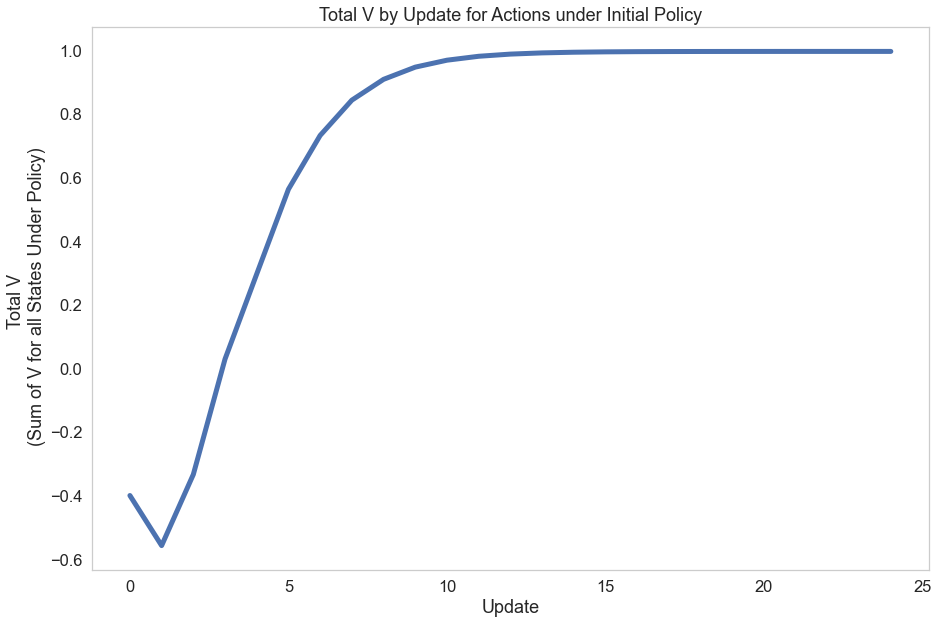

In [7]:
output_metric_table_init = output_metric_table.copy()
plt.plot(output_metric_table_init['sum_V'])
plt.ylabel("Total V \n (Sum of V for all States Under Policy)")
plt.xlabel("Update")
plt.title("Total V by Update for Actions under Initial Policy")
plt.show()

In [8]:
V_table_policy.head(15)

,state,x,y,action,V,u,v
1,A,4.0,1.0,left,-0.037385,-1.0,0.0
7,B,3.0,1.0,up,0.186779,0.0,1.0
10,C,2.0,1.0,right,0.084359,1.0,0.0
12,D,1.0,1.0,down,0.031022,0.0,0.0
16,E,1.0,2.0,down,0.058199,0.0,-1.0
20,F,1.0,3.0,down,0.153882,0.0,-1.0
25,G,2.0,3.0,left,0.293939,-1.0,0.0
30,M,3.0,2.0,right,-0.601203,1.0,0.0
34,T,3.0,3.0,right,0.826611,1.0,0.0
39,recycling,4.0,3.0,up,1.000000,0.0,0.0


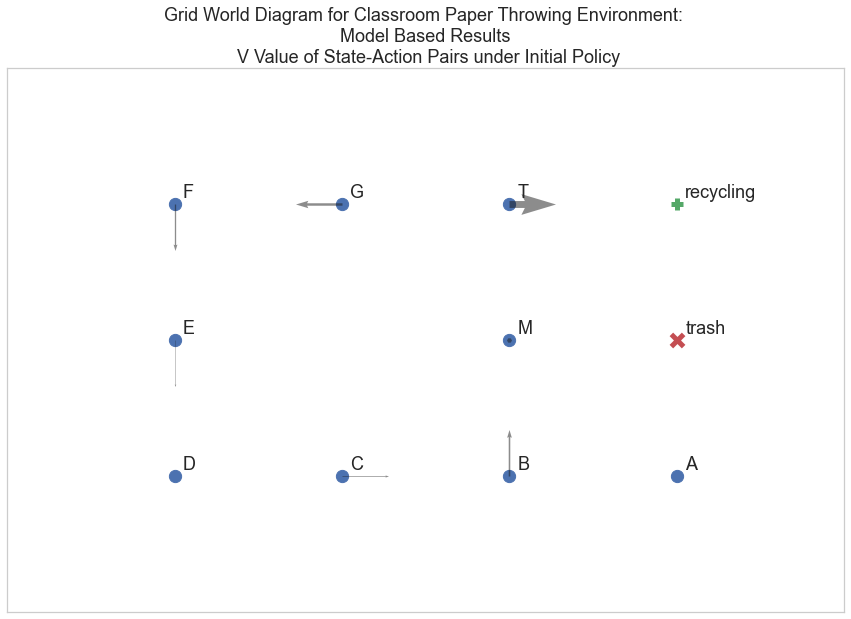

In [9]:
# Plot Q for actions in each state
for n,state in enumerate(states):
    if state == 'recycling':
        plt.scatter(x_list[n],y_list[n], s=150, color='g', marker='+')
    elif state == 'trash':
        plt.scatter(x_list[n],y_list[n], s=150, color='r', marker='x')
    else:
        plt.scatter(x_list[n],y_list[n], s=150, color='b')
    plt.text(x_list[n]+0.05,y_list[n]+0.05,states[n])
    V_table_state = V_table_policy[V_table_policy['state']==state].reset_index(drop=True)
    for action in range(0,len(V_table_state)):
        plt.quiver(x_list[n],y_list[n],V_table_state['u'][action],V_table_state['v'][action], alpha = 0.5,
                width = 0.01*V_table_state['V'][action])

plt.title("Grid World Diagram for Classroom Paper Throwing Environment: \n Model Based Results \n V Value of State-Action Pairs under Initial Policy")
plt.xticks([])
plt.yticks([])
plt.ylim(0,4)
plt.xlim(0,5)
plt.show()


In [10]:
V_table.head(10)

,state,x,y,action,V,u,v
0,A,4,1,down,-0.144985,0,0
1,A,4,1,left,-0.037385,-1,0
2,A,4,1,right,-0.144985,0,0
3,A,4,1,up,-0.703039,0,1
4,B,3,1,down,0.098080,0,0
5,B,3,1,left,0.048918,-1,0
6,B,3,1,right,-0.009519,1,0
7,B,3,1,up,0.186779,0,1
8,C,2,1,down,0.035197,0,0
9,C,2,1,left,0.032299,-1,0


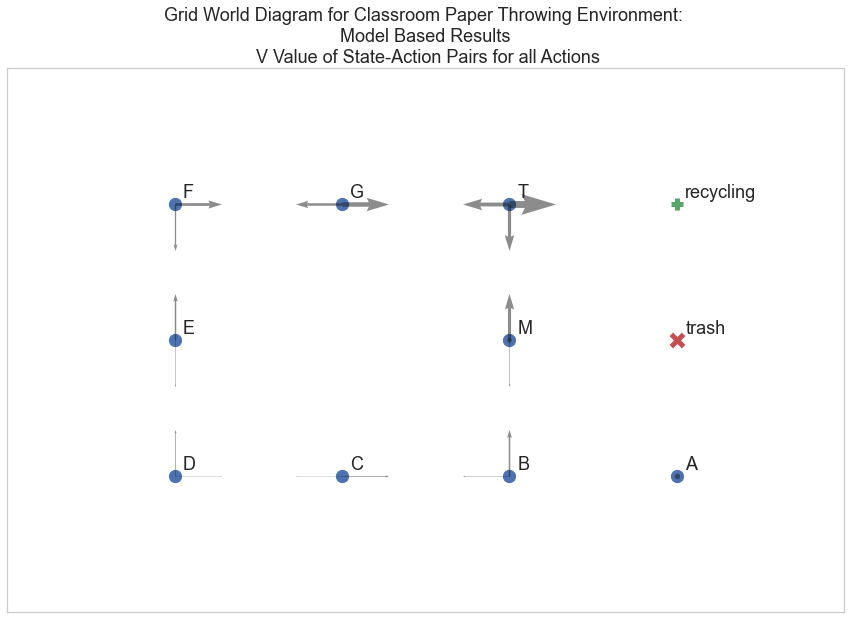

In [11]:
# Plot Q for actions in each state
for n,state in enumerate(states):
    if state == 'recycling':
        plt.scatter(x_list[n],y_list[n], s=150, color='g', marker='+')
    elif state == 'trash':
        plt.scatter(x_list[n],y_list[n], s=150, color='r', marker='x')
    else:
        plt.scatter(x_list[n],y_list[n], s=150, color='b')
    plt.text(x_list[n]+0.05,y_list[n]+0.05,states[n])
    V_table_state = V_table[V_table['state']==state].reset_index(drop=True)
    for action in range(0,len(V_table_state)):
        plt.quiver(x_list[n],y_list[n],V_table_state['u'][action],V_table_state['v'][action], alpha = 0.5,
                width = 0.01*V_table_state['V'][action])

plt.title("Grid World Diagram for Classroom Paper Throwing Environment: \n Model Based Results \n V Value of State-Action Pairs for all Actions")
plt.xticks([])
plt.yticks([])
plt.ylim(0,4)
plt.xlim(0,5)
plt.show()


### 6. Update the Policy

- Given the results previously, we update our policy by the actions that return the highest value.
- Comparing these in the final results show that our new policy returns a higher overall value of states.

In [12]:
input_table = value_table_init_V.copy()
policy = ['left','up','right','up','up','right','right','right','up','up','up'] 
gamma = 0.8
num_repeats = 25

start_time = time.time()
output_metric_table = pd.DataFrame()

# Begin loop with an arbitrary limit
for repeats in (range(0,num_repeats)):
    #--------------------------------------------------------------------------------------------------------------------
    # 1. Find the value of each state-action-outcome pair given the value of the resultant states and known probabilities
    ## value = P(s'|s,a)[r + gamma*V(s')]
    value_l = []
    for n,row in input_table.iterrows():
        # If terminal state reached, value is fixed as 0
        if (row['next_state'] == 'trash')|(row['next_state'] == 'recycling'):
            value = row['prob']*(row['reward'] + gamma*0)
        else:
            value = row['prob']*(row['reward'] + gamma*row['V_next'])

        value_l.append(value)
    
    input_table['value'] = value_l
    
    #--------------------------------------------------------------------------------------------------------------------
    # 2. Sum these values across all outcomes for a state-action pair
    ## V(s) = SUM(value) = SUM( P(s'|s,a)[r + gamma*V(s')] ) for all outcome states
    V_table = input_table[['state','x','y','action','value']].groupby(by=['state','x','y','action']).sum().reset_index(drop=False)
    V_table.columns = ['state','x','y','action','V']

    # Re-add columns for vector direction of the action
    # These are lost in the groupby function as they are summed
    u_l = []
    v_l = []
    for n,row in V_table.iterrows():
        state_x = row['x']
        state_y = row['y']
        state = row['state']
        action = row['action']
        
        u = action_outcome(state_x, state_y, action)[0]
        v = action_outcome(state_x, state_y, action)[1]
        u_l.append(u)
        v_l.append(v)
    V_table['u'] = u_l
    V_table['v'] = v_l

    #--------------------------------------------------------------------------------------------------------------------
    # 3. Find only the values for the current policy
    V_table_policy = pd.DataFrame()
    for n,row in V_table.iterrows():
        state = row['state']
        action = row['action']

        policy_a = policy[states.index(state)]        
        if action == policy_a:
            V_table_policy = V_table_policy.append(row)
        else:
            continue

    V_table_policy = V_table_policy[['state','x','y','action','V','u','v']]

    # Extract summary results to plot per update (for convergence check)
    output_metric_table = output_metric_table.append(pd.DataFrame({'mean_V':V_table_policy['V'].mean(), 
                                                                    'sum_V': V_table_policy['V'].sum()}, index = [repeats]))

    #--------------------------------------------------------------------------------------------------------------------
    # 4. Update the value table with the new V(s)
    ## First for the value of the current state and then for the value of the next state
    V_l = pd.DataFrame()
    for n,state in enumerate(states):
        V_table_state = V_table[(V_table['state']==state)]
        V = max(V_table_state['V'])
        V_l = V_l.append(pd.DataFrame({'state':state, 'V_update':V},index=[n]))
   
    input_table_V_update = input_table.merge(V_l[['state','V_update']], how='left', left_on='state', right_on='state')
    input_table_V_update['V'] = input_table_V_update['V_update']
    input_table_V_update = input_table_V_update.drop('V_update', axis=1)

    V_l.columns=['next_state','V_update']
    input_table_V_next_update = input_table_V_update.merge(V_l[['next_state','V_update']], how='left', left_on='next_state', right_on='next_state')
    input_table_V_next_update['V_next'] = input_table_V_next_update['V_update']
    input_table_V_next_update = input_table_V_next_update.drop('V_update', axis=1)

    input_table = input_table_V_next_update.copy()
    
    # 5. Repeat for next update until convergence
    #--------------------------------------------------------------------------------------------------------------------




end_time = time.time()

print("total time taken this loop: ", np.round((end_time - start_time),2), " seconds")



total time taken this loop:  2.93  seconds


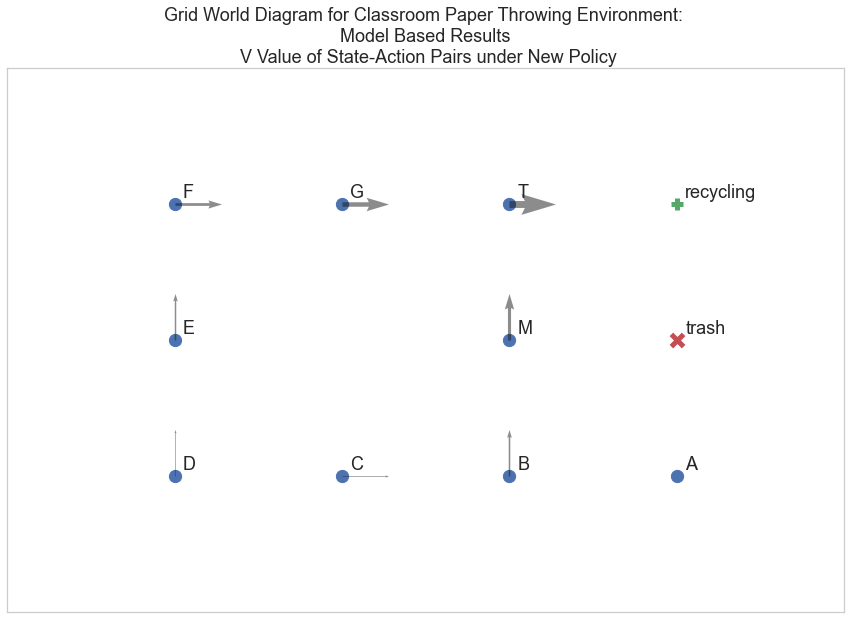

In [13]:
# Plot Q for actions in each state
for n,state in enumerate(states):
    if state == 'recycling':
        plt.scatter(x_list[n],y_list[n], s=150, color='g', marker='+')
    elif state == 'trash':
        plt.scatter(x_list[n],y_list[n], s=150, color='r', marker='x')
    else:
        plt.scatter(x_list[n],y_list[n], s=150, color='b')
    plt.text(x_list[n]+0.05,y_list[n]+0.05,states[n])
    V_table_state = V_table_policy[V_table_policy['state']==state].reset_index(drop=True)
    for action in range(0,len(V_table_state)):
        plt.quiver(x_list[n],y_list[n],V_table_state['u'][action],V_table_state['v'][action], alpha = 0.5,
                width = 0.01*V_table_state['V'][action])

plt.title("Grid World Diagram for Classroom Paper Throwing Environment: \n Model Based Results \n V Value of State-Action Pairs under New Policy")
plt.xticks([])
plt.yticks([])
plt.ylim(0,4)
plt.xlim(0,5)
plt.show()


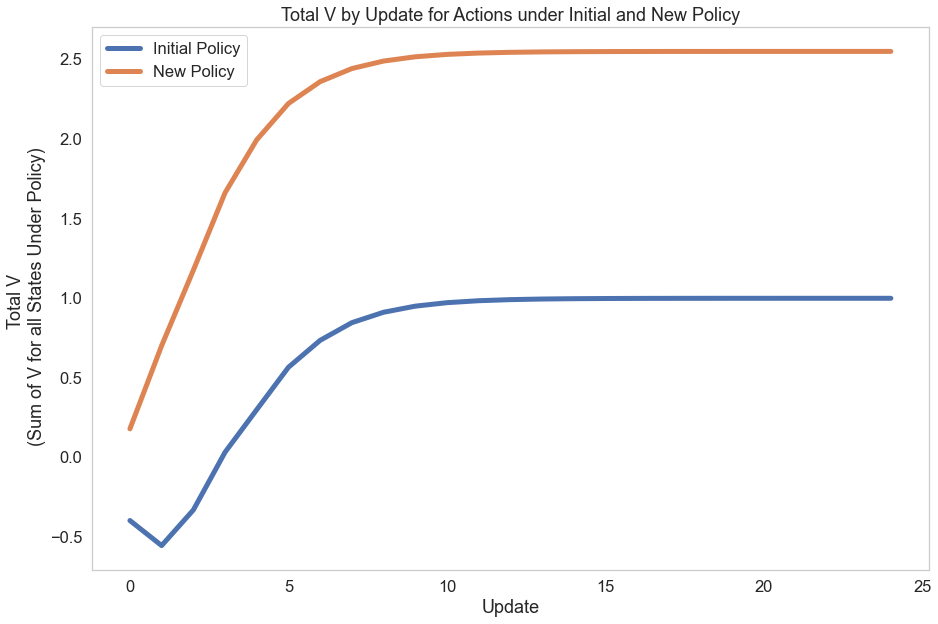

In [14]:
plt.plot(output_metric_table_init['sum_V'], label='Initial Policy')
plt.plot(output_metric_table['sum_V'], label = 'New Policy')
plt.ylabel("Total V \n (Sum of V for all States Under Policy)")
plt.xlabel("Update")
plt.title("Total V by Update for Actions under Initial and New Policy")
plt.legend()
plt.show()

## Conclusion

- We have applied Policy Iteration following the methodology introduce by Sutton.
- Our new policy outperforms out initial policy given the reward signal and known probabilities.
- The Optimal Policy is found after only 1 change because all of the probabilities are known and given by the trivial 70% chance to follow any command.
- Realistically, our probabilities should be more complex and actualy be dependent on the action direction.